This script takes an `xarray` Dataset that was generated from analysis of Calium data, and writes it to disk in such a way that it can be read and post-processed by `R` scripts which test the statistical significance of the different activity of two groups or more, with knowledge of the mouse ID that generated this data. Or in other words - ANOVA with a nested design. These functions currently don't exist in Python, which is why it had to be done in R.

The R scripts as well as this one are currently optimized for Amit's FMR-WT data, but that should be easily changed.

In [186]:
import pathlib
import itertools
import pickle

import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal
import scipy.spatial.distance

from calcium_bflow_analysis.single_fov_analysis import filter_da
from calcium_bflow_analysis.analyze_spike_delay_to_stim import iter_over_mouse_and_fname, get_dff_spikes_stim, get_shortest_delay_between_stim_and_spike, filter_spikes_that_occurred_out_of_bounds, assign_spikes_to_closest_stim, get_traces_around_spikes, delay_spikes_as_dff
from calcium_bflow_analysis.dff_analysis_and_plotting import dff_analysis
from calcium_bflow_analysis.dff_analysis_and_plotting.plot_cells_and_traces import rank_dff_by_stim, sort_spikes_by_stim, display_heatmap

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
foldername = pathlib.Path('/data/Amit_QNAP/Calcium_FXS/')
fname_glob = '*.nc'
full_fnames = list(foldername.glob(fname_glob))
full_fnames

[PosixPath('/data/Amit_QNAP/Calcium_FXS/data_of_day_1.nc')]

In [3]:
data = xr.open_dataset(full_fnames[0])

In [4]:
last_idx_per_fname = []
for gr in data['dff']:
    last_idx_per_fname.append(np.isfinite(gr.data).any(axis=1).sum())

We're now build a dictionary which divides the data into the different groupings. We'll pickle it to avoid running everything everytime, but besides that the dictionary is a helper variable that lets us construct specific dataframes containing only the relevant data. 

In [5]:
dff = filter_da(data, 'all')
fps = data.attrs['fps']
thresh = 0.70

fxs_wt = {'FXS': {'spont': {}, 'stim': {}, 'all': {}}, 'WT': {'spont': {}, 'stim': {}, 'all': {}}}
epochs = ('spont', 'stim', 'all')

for mouse_id, ds in data.groupby('mouse_id'):
    for epoch in epochs:
        try:
            dff = filter_da(ds, 'all')
            spikes = dff_analysis.locate_spikes_scipy(dff, fps=fps, thresh=thresh)
            dff = filter_da(ds, epoch)
            if dff.shape[0] < 1:
                print(f"dF/F shape of mouse {mouse_id} in epoch {epoch} contained too few rows.")
                continue
            if (spikes * np.isfinite(dff)).sum() == 0.0:
                print(f"No spikes for epoch {epoch} and mouse {mouse_id}")
                continue
            condition = str(ds.condition[0].values)
            mean_auc = dff_analysis.calc_mean_auc_around_spikes(spikes, dff, fps)
            
            mean_spike_rate = dff_analysis.calc_mean_spike_num(spikes, dff, fps)
            total_auc = dff_analysis.calc_total_auc_around_spikes(spikes, dff, fps)
            median_auc = dff_analysis.calc_median_auc_around_spikes(spikes, dff, fps)
            fxs_wt[condition][epoch][mouse_id] = {
                'mean_auc': mean_auc, 
                'mean_spike_rate': mean_spike_rate, 
                'total_auc': total_auc, 
                'median_auc': median_auc
            }
        except AssertionError:  # some mice don't have all epochs
            continue

/data/MatlabCode/PBLabToolkit/CalciumDataAnalysis/python-ca-analysis-bloodflow/calcium_bflow_analysis/dff_analysis_and_plotting/dff_analysis.py:274: RuntimeWarning: Mean of empty slice
  return np.nan_to_num(np.nanmean(auc, axis=1))
/opt/miniconda3/envs/caiman/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


dF/F shape of mouse 293 in epoch stim contained too few rows.
No spikes for epoch spont and mouse 517
No spikes for epoch stim and mouse 517
No spikes for epoch all and mouse 517
dF/F shape of mouse 595 in epoch stim contained too few rows.
dF/F shape of mouse 596 in epoch stim contained too few rows.
No spikes for epoch stim and mouse 650


In [6]:
print(f"FXS mice: {fxs_wt['FXS']['all'].keys()}")
print(f"WT mice: {fxs_wt['WT']['all'].keys()}")

FXS mice: dict_keys(['518', '609', '614', '647', '648', '650'])
WT mice: dict_keys(['293', '595', '596', '615', '640', '674'])


In [7]:
for fname in full_fnames:
    with open(fname.with_suffix('.p'), 'wb') as f:
        pickle.dump(fxs_wt, f)

In [8]:
df_list = []
for geno, genodata in fxs_wt.items():
    for epoch, epochdata in genodata.items():
        for mid, midata in epochdata.items():
            for measure, measurement in midata.items():
                df_list.append(pd.DataFrame({'Epoch': epoch, 'Genotype': geno, 'MouseID': mid, 'Measure': measure, 'Value': measurement}))
                
df = pd.concat(df_list, ignore_index=True)

In [9]:
measures = ('mean_auc', 'mean_spike_rate', 'total_auc', 'median_auc')

for epoch in epochs:
    for measure in measures:
        cur_data = df.query(f'Epoch == "{epoch}" and Measure == "{measure}"')
        cur_data.loc[:, ['Genotype', 'MouseID', 'Value']].to_csv(fname.with_name(f'epoch_{epoch}_measure_{measure}.csv'), index=False)

In [10]:
# %matplotlib notebook
# window_length = 6
# post_stim_window = int(window_length * fps)
# for mouse_id, ds in data.groupby('mouse_id'):
#     for epoch in ['all']:
#         try:
#             dff = filter_da(ds, 'all')
#             spikes = dff_analysis.locate_spikes_scipy(dff, fps=fps, thresh=thresh)
#             dff = filter_da(ds, epoch)
#             where = np.where(np.isfinite(dff))
#             num_cells = len(np.unique(where[0]))
#             dff = dff[where].reshape(num_cells, -1)
#             stim = ds['epoch_times'].data[0][0][:dff.shape[1]]
#             rank_dff_by_stim(dff, spikes, stim, fps)
#             post_stim = np.full_like(stim, False)
#             stim_ends = np.where(np.diff(stim))[0][1::2]
#             for end in stim_ends:
#                 post_stim[end:(end + post_stim_window)] = True
#             relevant_spikes = (spikes * post_stim).sum() / len(spikes)
#             non_post_stim = ~post_stim
#             non_post_stim[stim] = False
#             irrelevant_spikes = (spikes * non_post_stim).sum() / len(spikes)
#             length_of_non_post_stim = non_post_stim.sum() / fps
#             print(f"Mouse ID: {mouse_id} (above this message)")
#             print(f"Average spike rate in post stim is {relevant_spikes / window_length}")
#             print(f"While the average spike rate everywhere else is {irrelevant_spikes / length_of_non_post_stim}")
#         except (AssertionError, ValueError):
#             continue

Here we wish to do some hack to the analog data where by we add another epoch to the list of epochs - a "post-post stimulus" epoch which captures the dF/F and spikes made about 3-4 s after each stimulus.

To do so we're not really going to patch the AnalogTreadmill class - it's old, needs a massive refactor and very uncomfortable to work with - so instead we'll read the dF/F data and the stimulus data, find the peaks corresponding to real spikes and then look at the data in the post-post interval. This should be fairly simple, but not generalizable to other analysis scripts.

FXS mice: dict_keys(['518', '609', '614', '647', '648', '650'])
WT mice: dict_keys(['293', '595', '596', '615', '640', '674'])

Of the four mice, all reported higher activation in the post-post window, and 3 of them were FXS.

We'll now try to visualize all traces together

In [11]:
fxs = ['518', '609', '614', '647', '648', '650']
wt = ['293', '595', '596', '615', '640', '674']
bloats = {'fxs': [], 'wt': []}
for mouse_id, ds in data.groupby('mouse_id'):
    print(f"Mouse {mouse_id}")
    for epoch in ['all']:
        try:
            dff = filter_da(ds, 'all')
            spikes = dff_analysis.locate_spikes_scipy(dff, fps=fps, thresh=thresh)
            bloated = get_traces_around_spikes(spikes, dff, fps, 3)
            if mouse_id in fxs:
                bloats['fxs'].append(bloated)
            elif mouse_id in wt:
                bloats['wt'].append(bloated)
        except (AssertionError, ValueError) as e:
            print(f"Error! {e}")
            continue

Mouse 293
Mouse 517
Mouse 518
Mouse 595
Mouse 596
Mouse 609
Mouse 614
Mouse 615
Mouse 640
Mouse 647
Mouse 648
Mouse 650
Mouse 674


In [12]:
print(len(bloats['fxs']))
print(len(bloats['wt']))

6
6


In [13]:
fxs = np.concatenate(bloats['fxs'])
fxs_indices = np.tile(np.arange(fxs.shape[0])[:, np.newaxis], (1, fxs.shape[1])).ravel()
fxs_times = np.tile(np.arange(fxs.shape[1]) / fps, (fxs.shape[0], 1)).ravel()
fxs = fxs.ravel()
fxs_labels = ['FXS'] * len(fxs)
wt = np.concatenate(bloats['wt'])
wt_indices = np.tile(np.arange(wt.shape[0])[:, np.newaxis], (1, wt.shape[1])).ravel()
wt_times = np.tile(np.arange(wt.shape[1]) / fps, (wt.shape[0], 1)).ravel()
wt = wt.ravel()
wt_labels = ['WT'] * len(wt)
data_for_display = pd.DataFrame(
    {
        'data': np.concatenate([fxs, wt]), 
        'indices': np.concatenate([fxs_indices, wt_indices]),
        'labels': np.concatenate([fxs_labels, wt_labels]),
        'timestamps': np.concatenate([fxs_times, wt_times]),
    }
)

In [14]:
data_for_display

,data,indices,labels,timestamps
0,-0.026729,0,FXS,0.000000
1,0.032653,0,FXS,0.033289
2,0.033021,0,FXS,0.066578
3,-0.117211,0,FXS,0.099867
4,-0.017024,0,FXS,0.133156
...,...,...,...,...
1309495,-0.016217,9471,WT,2.829561
1309496,0.699298,9471,WT,2.862850
1309497,-0.038190,9471,WT,2.896138
1309498,0.221444,9471,WT,2.929427


<AxesSubplot:xlabel='timestamps', ylabel='data'>

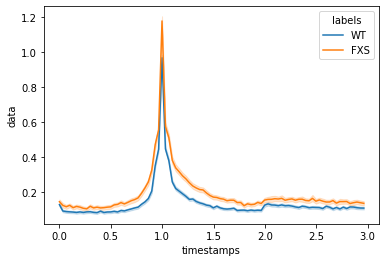

In [15]:
sns.lineplot(data=data_for_display, x='timestamps', y='data', hue='labels', hue_order=['WT', 'FXS'])

In [16]:
del data_for_display

In [17]:
for mouse_id, ds in data.groupby('mouse_id'):
    print(f"Mouse {mouse_id}")
    for fname in ds.fname:
        try:
            dff = filter_da(ds, 'all')
            spikes = dff_analysis.locate_spikes_scipy(dff, fps=fps, thresh=thresh)
            stim = ds['epoch_times'].sel(epoch='stim', fname=fname)
            sorted_spikes = sort_spikes_by_stim(dff, spikes, stim, fps)
        except (AssertionError, ValueError) as e:
            print(f"Error! {e}")
            continue
        

Mouse 293
Mouse 517
Mouse 518
Mouse 595
Mouse 596
Mouse 609
Mouse 614
Mouse 615
Mouse 640
Mouse 647
Mouse 648
Mouse 650
Mouse 674


Now we turn to look at the different sub-populations of neurons that are hidden in the data with respect to their spike time since the start of the stimulus.

In [18]:
def get_mouse_id_from_ds(ds):
    all_ids = ds.mouse_id.values
    try:
        len(all_ids)
    except TypeError:
        mouse_id = all_ids
    else:
        mouse_id = all_ids[0]
    return mouse_id

In [51]:
MIN_DELAY_BETWEEN_STIM_AND_SPIKE = int(0 * fps)
MAX_DELAY_BETWEEN_STIM_AND_SPIKE = int(10 * fps)
fxs = ['518', '609', '614', '647', '648', '650']
wt = ['293', '595', '596', '615', '640', '674']
epoch = 'all'
all_fxs_spikes = []
all_fxs_delays = []
all_wt_spikes = []
all_wt_delays = []
per_fname_ds_iter = iter_over_mouse_and_fname(data)
for ds in per_fname_ds_iter:
    fps = ds.fps
    mouse_id = get_mouse_id_from_ds(ds)
    try:
        dff, spikes, stim = get_dff_spikes_stim(ds, epoch, fps)
        shortest_delay_from_stim_per_spike, new_spike_matrix = assign_spikes_to_closest_stim(
            spikes, 
            stim, 
            (MIN_DELAY_BETWEEN_STIM_AND_SPIKE, MAX_DELAY_BETWEEN_STIM_AND_SPIKE),
        )
    except ValueError:
        print(f"No spikes occurred in {ds.fname.values}")
        continue
    bloated = get_traces_around_spikes(new_spike_matrix, dff, fps, 3)
    assert len(bloated) == len(shortest_delay_from_stim_per_spike)
    total_window = 13
    spikes, delays = delay_spikes_as_dff(bloated, shortest_delay_from_stim_per_spike, total_window, fps)
    if mouse_id in fxs:
        all_fxs_spikes.append(spikes)
        all_fxs_delays.append(delays)
    elif mouse_id in wt:
        all_wt_spikes.append(spikes)
        all_wt_delays.append(delays)
        
all_fxs_spikes = np.concatenate(all_fxs_spikes)
all_fxs_delays = np.concatenate(all_fxs_delays)
all_wt_spikes = np.concatenate(all_wt_spikes)
all_wt_delays = np.concatenate(all_wt_delays)

Mouse 293; file WT_293_X10_mag3_30Hz_20180627_00003
No spikes occurred in WT_293_X10_mag3_30Hz_20180627_00003
Mouse 293; file WT_293_X10_mag3_30Hz_20180627_00002
No spikes occurred in WT_293_X10_mag3_30Hz_20180627_00002
Mouse 293; file WT_293_X10_mag3_30Hz_20180627_00001
No spikes occurred in WT_293_X10_mag3_30Hz_20180627_00001
Mouse 517; file FXS_517_fmr_Cage505_FOV2_X25_mag2p5_20180822_00001
No spikes occurred in FXS_517_fmr_Cage505_FOV2_X25_mag2p5_20180822_00001
Mouse 517; file FXS_517_fmr_Cage505_FOV3_X25_mag2p5_20180822_00001
No spikes occurred in FXS_517_fmr_Cage505_FOV3_X25_mag2p5_20180822_00001
Mouse 517; file FXS_517_fmr_Cage505_FOV4_X25_mag2p5_20180822_00001
No spikes occurred in FXS_517_fmr_Cage505_FOV4_X25_mag2p5_20180822_00001
Mouse 517; file FXS_517_fmr_Cage505_FOV5_X25_mag2p5_20180822_00001
No spikes occurred in FXS_517_fmr_Cage505_FOV5_X25_mag2p5_20180822_00001
Mouse 518; file FXS_518_fmr_Cage505_FOV3_X25_mag2p5_20180822_00001
Mouse 518; file FXS_518_fmr_Cage505_FOV6_X2

In [52]:
all_fxs_delays = np.repeat(all_fxs_delays, all_fxs_spikes.shape[1])
fxs_labels = np.full(all_fxs_spikes.size, 'FXS')
fxs_spike_ids = np.repeat(
    np.arange(len(all_fxs_spikes), dtype=np.uint16), 
    all_fxs_spikes.shape[1]
)
all_wt_delays = np.repeat(all_wt_delays, all_wt_spikes.shape[1])
wt_labels = np.full(all_wt_spikes.size, 'WT')
wt_spike_ids = np.repeat(
    np.arange(len(all_fxs_spikes), len(all_fxs_spikes) + len(all_wt_spikes), dtype=np.uint16), 
    all_wt_spikes.shape[1]
)
time = np.tile(
    (np.arange(all_fxs_spikes.shape[1]) / fps).astype(np.float32), 
    (len(all_fxs_spikes) + len(all_wt_spikes), 1)
)

spike_dff_and_delay = pd.DataFrame(
    {
        'dff': np.concatenate([all_fxs_spikes.ravel(), all_wt_spikes.ravel()]), 
        'time': time.ravel(),
        'delay': np.concatenate([all_fxs_delays.ravel(), all_wt_delays.ravel()]),
        'condition': np.concatenate([fxs_labels, wt_labels]),
        'spike_id': np.concatenate([fxs_spike_ids, wt_spike_ids]),
    }
).astype(
    {
        'spike_id': 'category', 
        'condition': 'category'
    }
)
spike_dff_and_delay

,dff,time,delay,condition,spike_id
0,0.0,0.000000,2.896138,FXS,0
1,0.0,0.033289,2.896138,FXS,0
2,0.0,0.066578,2.896138,FXS,0
3,0.0,0.099867,2.896138,FXS,0
4,0.0,0.133156,2.896138,FXS,0
...,...,...,...,...,...
5339095,0.0,12.816245,9.154461,WT,13689
5339096,0.0,12.849534,9.154461,WT,13689
5339097,0.0,12.882823,9.154461,WT,13689
5339098,0.0,12.916112,9.154461,WT,13689


In [53]:
spike_dff_and_delay['delay_group'] = np.uint8(20)
spike_dff_and_delay.loc[spike_dff_and_delay.query('delay < 10').index, 'delay_group'] = np.uint8(10)
spike_dff_and_delay.loc[spike_dff_and_delay.query('delay < 7').index, 'delay_group'] = np.uint8(7)
spike_dff_and_delay.loc[spike_dff_and_delay.query('delay < 4').index, 'delay_group'] = np.uint8(4)
spike_dff_and_delay.loc[spike_dff_and_delay.query('delay < 2').index, 'delay_group'] = np.uint8(2)
spike_dff_and_delay = spike_dff_and_delay.astype({'delay_group': 'category'})

<AxesSubplot:xlabel='time', ylabel='dff'>

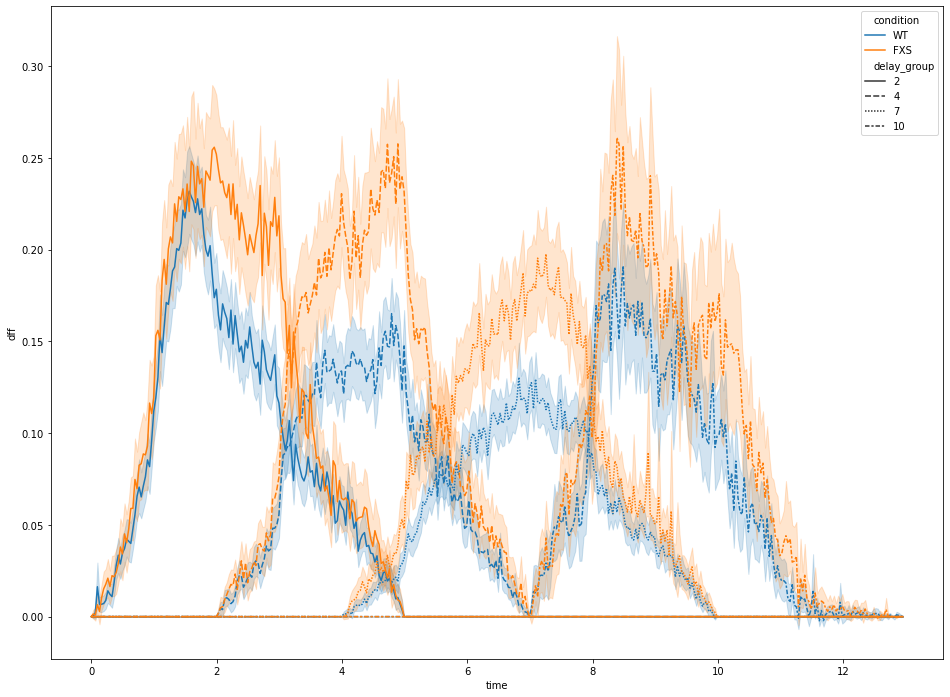

In [54]:
fig, ax = plt.subplots(figsize=(16, 12))

sns.lineplot(
    data=spike_dff_and_delay, 
    x='time', 
    y='dff', 
    hue='condition', 
    hue_order=['WT', 'FXS'], 
    style='delay_group', 
    ax=ax
)

What we see is that different subpopulation of spikes are responsible for different parts of the summed activity. We'll now try to find the underlying cause by looking at the PSTH at the image of the arranged neurons.

In [55]:
def align_spikes_to_array(spikes: list) -> np.ndarray:
    max_columns = max([spk.shape[1] for spk in spikes])
    padded_spikes = []
    for spk in spikes:
        if spk.shape[1] < max_columns:
            spk = np.pad(spk, (0, max_columns - spk.shape[1]))
        padded_spikes.append(spk)
    return np.concatenate(padded_spikes)

In [179]:
all_fxs_spikes = []
all_fxs_dff = []
all_wt_spikes = []
all_wt_dff = []
per_fname_ds_iter = iter_over_mouse_and_fname(data)
for ds in per_fname_ds_iter:
    fps = ds.fps
    mouse_id = get_mouse_id_from_ds(ds)
    try:
        dff, spikes, stim = get_dff_spikes_stim(ds, epoch, fps)
        stim_start_indices = np.where(np.concatenate([np.diff(stim), [False]]))[0][::2]
        num_cells = len(spikes)
        smallest_diff = np.diff(stim_start_indices).min()
    except ValueError:
        continue

    # For each stimulus in the filename we'll cut out the activity following it
    # and copy it to an array. This array will be averaged with the number of stimuli
    # that occurred in this recording, creating a per-cell activity map.
    spikes_psth = np.zeros((num_cells, smallest_diff), dtype=np.uint8)
    dff_image = np.zeros(spikes_psth.shape, dtype=np.float32)
    for idx, stim_start_index in enumerate(stim_start_indices):
        current_spikes = spikes[:, stim_start_index:stim_start_index+smallest_diff]
        spikes_psth[:, :current_spikes.shape[1]] += current_spikes
        current_dff = dff[:, stim_start_index:stim_start_index+smallest_diff]
        dff_image[:, :current_dff.shape[1]] += current_dff
    
    if mouse_id in fxs:
        all_fxs_spikes.append(spikes_psth / (idx + 1))
        all_fxs_dff.append(dff_image / (idx + 1))
    elif mouse_id in wt:
        all_wt_spikes.append(spikes_psth / (idx + 1))
        all_wt_dff.append(dff_image / (idx + 1))
        
all_fxs_spikes = align_spikes_to_array(all_fxs_spikes)
all_fxs_dff = align_spikes_to_array(all_fxs_dff)
all_wt_spikes = align_spikes_to_array(all_wt_spikes)
all_wt_dff = align_spikes_to_array(all_wt_dff)

Mouse 293; file WT_293_X10_mag3_30Hz_20180627_00003
Mouse 293; file WT_293_X10_mag3_30Hz_20180627_00002
Mouse 293; file WT_293_X10_mag3_30Hz_20180627_00001
Mouse 517; file FXS_517_fmr_Cage505_FOV2_X25_mag2p5_20180822_00001
Mouse 517; file FXS_517_fmr_Cage505_FOV3_X25_mag2p5_20180822_00001
Mouse 517; file FXS_517_fmr_Cage505_FOV4_X25_mag2p5_20180822_00001
Mouse 517; file FXS_517_fmr_Cage505_FOV5_X25_mag2p5_20180822_00001
Mouse 518; file FXS_518_fmr_Cage505_FOV3_X25_mag2p5_20180822_00001
Mouse 518; file FXS_518_fmr_Cage505_FOV6_X25_mag2p5_20180822_00001
Mouse 518; file FXS_518_fmr_Cage505_FOV5_X25_mag2p5_20180822_00001
Mouse 518; file FXS_518_fmr_Cage505_FOV2_X25_mag2p5_20180822_00001
Mouse 518; file FXS_518_fmr_Cage505_FOV1_X25_mag2p5_20180822_00001
Mouse 595; file WT_595_X10_mag3_30Hz_20180627_00001
Mouse 595; file WT_595_X10_mag3_30Hz_20180627_00004
Mouse 595; file WT_595_X10_mag3_30Hz_20180627_00006
Mouse 595; file WT_595_X10_mag3_30Hz_20180627_00003
Mouse 595; file WT_595_X10_mag3_3

In [180]:
spike_rows_wt, spike_time_wt = np.where(all_wt_spikes)
spike_rows_fxs, spike_time_fxs = np.where(all_fxs_spikes)
spike_time_wt = spike_time_wt / fps
spike_time_fxs = spike_time_fxs / fps
fxs_labels = np.full(spike_time_fxs.shape, 'FXS')
wt_labels = np.full(spike_time_wt.shape, 'WT')
spike_hist_data = pd.DataFrame(
    {
        'spike_times': np.concatenate([spike_time_wt, spike_time_fxs]), 
        'labels': np.concatenate([wt_labels, fxs_labels])
    }
)

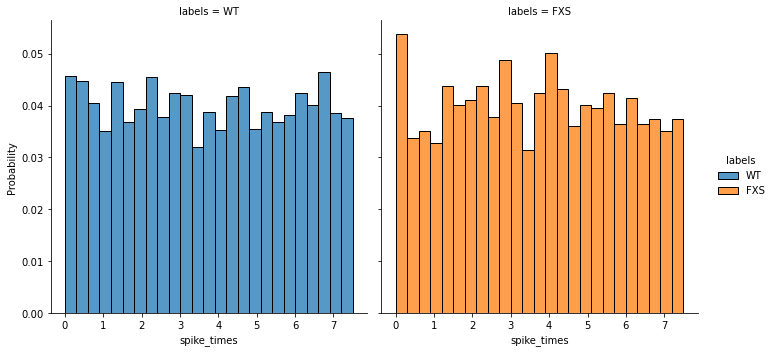

In [198]:
ax = sns.displot(
    data=spike_hist_data.query('spike_times < 7.5'), 
    x='spike_times', 
    col='labels',
    binwidth=0.3,
    hue='labels',
    hue_order=['WT', 'FXS'],
    stat='probability',
    common_norm=False,
)
ax.savefig('/home/hagaihargil/psth.pdf', transparent=True, dpi=300)

/data/MatlabCode/PBLabToolkit/CalciumDataAnalysis/python-ca-analysis-bloodflow/calcium_bflow_analysis/dff_analysis_and_plotting/plot_cells_and_traces.py:193: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.set_ylabel("Cell ID")


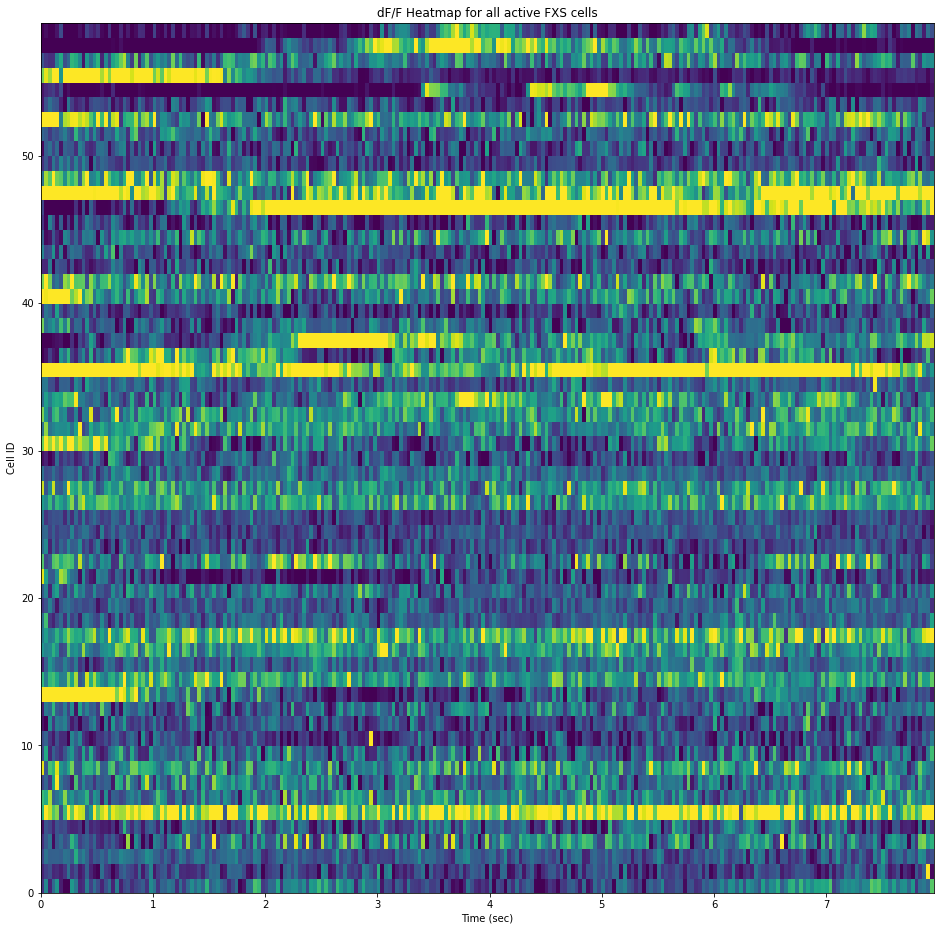

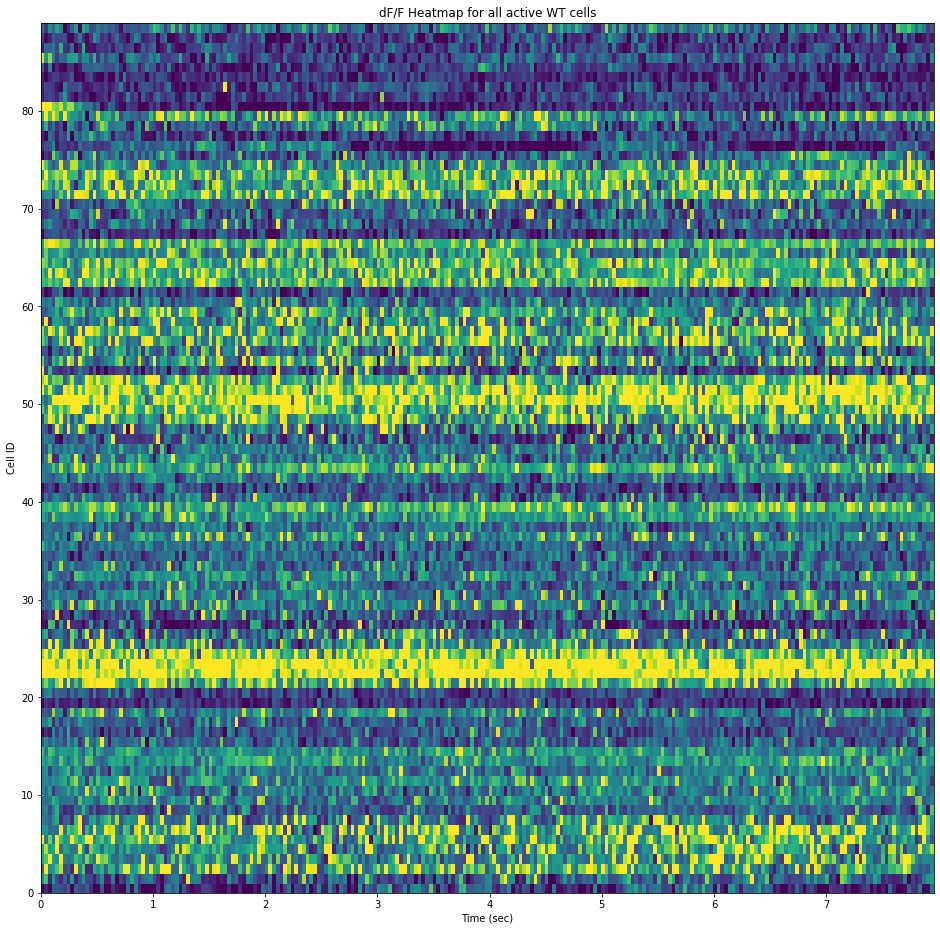

In [187]:
fig_fxs, ax_fxs = plt.subplots(figsize=(16, 16))
fxs_for_display = all_fxs_dff[all_fxs_dff.mean(1) > 0.1]
wt_for_display = all_wt_dff[all_wt_dff.mean(1) > 0.1]
colorscale = display_heatmap(fxs_for_display[:, :240], downsample_factor=(1, 1), ax=ax_fxs, epoch="all active FXS cells")
fig_wt, ax_wt = plt.subplots(figsize=(16, 16))
display_heatmap(wt_for_display[:, :240], downsample_factor=(3, 1), ax=ax_wt, epoch="all active WT cells", colorscale=colorscale)

fig_fxs.savefig('/home/hagaihargil/fxs_heatmap.png', dpi=300, transparent=True)
fig_wt.savefig('/home/hagaihargil/wt_heatmap.png', dpi=300, transparent=True)

/opt/miniconda3/envs/caiman/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "Transparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  # This is added back by InteractiveShellApp.init_path()


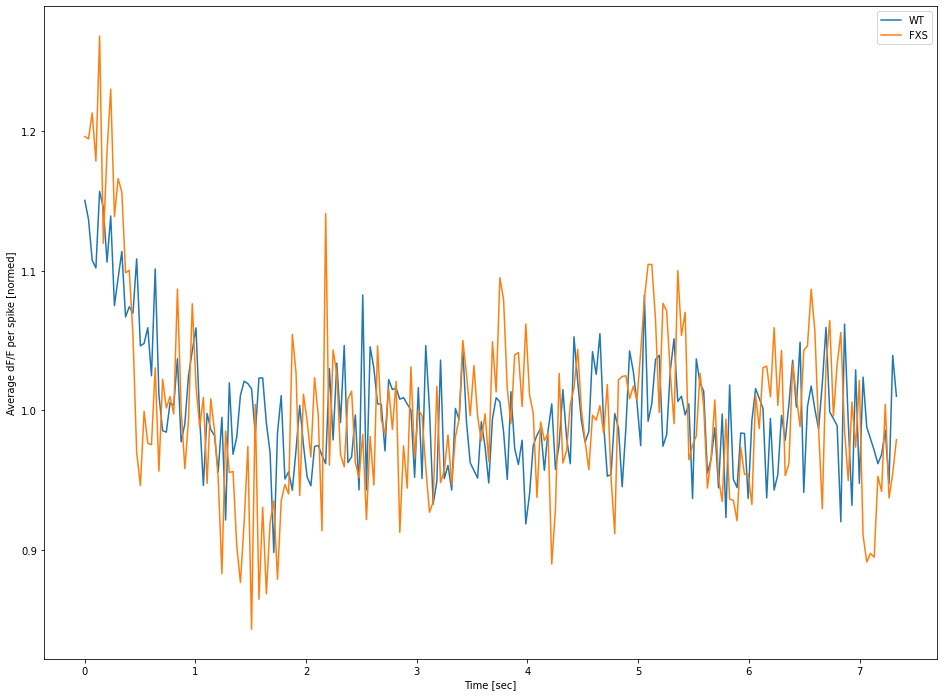

In [193]:
fig, ax = plt.subplots(figsize=(16, 12))
max_time_in_samples = 220
time = np.linspace(0, max_time_in_samples/30, max_time_in_samples)
wt_avg = all_wt_dff[:, :max_time_in_samples].mean(0)
fxs_avg = all_fxs_dff[:, :max_time_in_samples].mean(0)
ax.plot(time, wt_avg / wt_avg.mean(), label='WT')
ax.plot(time, fxs_avg / fxs_avg.mean(), label='FXS')
ax.set_xlabel('Time [sec]')
ax.set_ylabel('Average dF/F per spike [normed]')
ax.legend()
fig.savefig('/home/hagaihargil/avg_dff_normed.pdf', Transparent=True, dpi=300)